Wir beginnen mit dem Importieren der notwendigen Packages und Daten. Wie oben bereits kurz erwähnt, handelt es sich um den Datensatz einer Bank mit der Auflistung von vergebenen Krediten und den jeweiligen Kunden.

In [1]:
# import packages
import pandas as pd
from kmodes.kprototypes import KPrototypes

# read data
df_raw_data = pd.read_csv("german_credit_data.csv")

print("samples:", len(df_raw_data), "\n")

print(list(df_raw_data.columns), "\n")

print(df_raw_data.head())

samples: 1000 

['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose'] 

   Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car  


Unser Datensatz hat 1000 Einträge, wobei jeder dieser Einträge mehrere Attribute, wie z.B. Alter, Geschlecht oder Höhe des vergebenen Kredits besitzt. Bevor wir uns dem eigentlichen Datensatz widmen, möchten wir uns aber mit der Methodik etwas besser vertraut machen. Daher erzeugen wir uns einen Test-Datensatz, in dem nur die Attribute Alter, Geschlecht und Wohnsituation vorhanden sind. Außerdem manipulieren wir den Datensatz so, dass alle Frauen das Alter 30 haben und in einem Eigenheim wohnen. Alle Männer sind 40 Jahre alt und wohnen zur Miete. Dieser Test-Datensatz sollte also bei Anwendung des k-Prototype Clustering Verfahrens und bei k=2 Clustern in genau diese beiden Cluster "30 Jahre alte Frauen mit Eigenheim" und "40 Jahre alte Männer, die zur Miete wohnen" unterteilt werden.

In [2]:
# delete first columns with index
df_test = df_raw_data.drop(df_raw_data.columns[0], axis=1)

# select columns
df_test = df_test[['Age','Sex','Housing']]

# set test values
df_test.loc[df_test['Sex'] == 'female', ['Housing', 'Age']] = ['own', 30]
df_test.loc[df_test['Sex'] == 'male', ['Housing', 'Age']] = ['rent', 40]

print(df_test.head())

   Age     Sex Housing
0   40    male    rent
1   30  female     own
2   40    male    rent
3   40    male    rent
4   40    male    rent


Für den k-Prototype Algorythmus müssen wir angeben, welche der Attribute (Spalten) numerische Daten und welche kategorische Daten enthalten. Wir definieren weiterhin, dass wir k=2 Cluster bilden möchten. Nach der Clusterbildung fügen wir die Information der Clusterzugehörigkeit der Test-Daten hinzu. 

In [3]:
# define columns with numerical and categorial data
columns_numerical = [0]
columns_categorial = [1,2]

column_names_numerical = list(df_test.columns[columns_numerical].values)
column_names_categorial = list(df_test.columns[columns_categorial].values)

# k-prototypes algorithm
kp = KPrototypes(n_clusters=2, init='Huang', n_init=1, verbose=1)
clusters = kp.fit_predict(df_test, categorical=columns_categorial)

# add cluster info to data
df_test['Cluster'] = clusters

print("\n", df_test.head())

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/0, moves: 0, ncost: 0.0

    Age     Sex Housing  Cluster
0   40    male    rent        0
1   30  female     own        1
2   40    male    rent        0
3   40    male    rent        0
4   40    male    rent        0


Der erste Blick auf die Clusterzugehörigkeit scheint unser erwartetes Ergebnis erzeugt zu haben. Um die Zuordnung aber über alle Daten zu prüfen, analysieren wir die Clusterbildung noch etwas detaillierter.

In [4]:
# cluster analysis
df_cluster_analysis = df_test.copy()
columns_names_cluster_analysis = []
for i in column_names_categorial:
    list_unique = list(df_test[i].unique())
        
    for k in list_unique:
        count_current = len(df_test[df_test[i]==k])
        
        df_cluster_analysis[k] = 0
        df_cluster_analysis.loc[df_cluster_analysis[i] == k, [k]] = 1/count_current
        
        columns_names_cluster_analysis.append(k)

# numerical data
df_cluster_analysis_numerical = df_cluster_analysis[column_names_numerical+['Cluster']].groupby(['Cluster']).mean()

# categorial data
df_cluster_analysis_categorial = df_cluster_analysis[columns_names_cluster_analysis+['Cluster']].groupby(['Cluster']).sum()

# all data
df_cluster_analysis = pd.concat([df_cluster_analysis_numerical, df_cluster_analysis_categorial], axis=1)
df_cluster_analysis['Count'] = df_test['Cluster'].value_counts().sort_index() 
df_cluster_analysis['Share'] = df_test['Cluster'].value_counts(normalize=True).sort_index() 

print(df_cluster_analysis.head())

         Age  male  female  rent  own  Count  Share
Cluster                                            
0         40   1.0     0.0   1.0  0.0    690   0.69
1         30   0.0     1.0   0.0  1.0    310   0.31


Cluster "0" hat ein Durchschnittsalter von 30 Jahren und 100% der Frauen sowie 100% der Kunden mit Eigenheim sind diesem Cluster zugeordnet. Cluster "1" hat ein Durchschnittsalter von 40 Jahren und 100% der Männer sowie 100% der Kunden mit Mietwohnungen sind diesem Cluster zugeordnet. Die Clusterbildung der Test-Daten ist also wie erwartet erfolgt, sodass wir uns nun wieder den originalen Daten widmen können, wobei wir auch hier eine Auswahl der vorhandenen Attribute treffen.

In [5]:
# import additional packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# delete first columns with index
df_filtered = df_raw_data.drop(df_raw_data.columns[0], axis=1)

# select columns
df_filtered = df_filtered[['Age','Job','Housing','Credit amount']]

print("samples:", len(df_filtered), "\n")

print(df_filtered.head())

samples: 1000 

   Age  Job Housing  Credit amount
0   67    2     own           1169
1   22    2     own           5951
2   49    1     own           2096
3   45    2    free           7882
4   53    2    free           4870


Da die Jobbezeichnungen in den Rohdaten noch mit Integer Werten codiert sind, benennen wir diese entsprechend der dem Datensatz beigefügten Datenbeschreibung um. Außerdem normieren wir die numerischen Daten mittels MinMax-Skalierung, bei der der jeweils größte Wert einer Spalte nach der Skalierung den Wert 1 besitzt und der kleinste den Wert 0. Dieser Zwischenschritt soll verhindern, dass die unterschiedlichen Größenordnungen der Werte von Alter und Kredithöhe die Distanzberechnung beeinflussen. Für die spätere Rücktransformation müssen wir uns die jeweils kleinsten und größten Werte merken.

In [9]:
# rename certain data for easier interpretability
df_filtered['Job'] = df_filtered['Job'].replace({0 : 'unskilled non resident', 1 : 'unskilled resident', 2 : 'skilled', 3 : 'highly skilled'})

# min-max-scaling
max_age = df_filtered['Age'].max()
min_age = df_filtered['Age'].min()

max_credit = df_filtered['Credit amount'].max()
min_credit = df_filtered['Credit amount'].min()

scaler = MinMaxScaler()
df_filtered['Age'] = scaler.fit_transform(df_filtered['Age'].values.reshape(-1,1))
df_filtered['Credit amount'] = scaler.fit_transform(df_filtered['Credit amount'].values.reshape(-1,1))

Nun folgt das k-Prototype Clustering, wobei wir zunächst identifizieren wollen, wieviele Cluster sinnvollerweise gewählt werden sollten. Dazu variieren wir die Anzahl der Cluster und führen das Verfahren mehrfach mit den unterschiedlichen Werten für k durch.

Text(0,0.5,'loss')

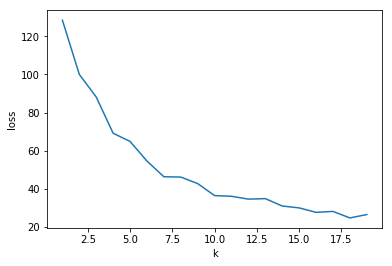

In [7]:
# define columns with numerical and categorial data
columns_numerical = [0,3]
columns_categorial = [1,2]

column_names_numerical = list(df_filtered.columns[columns_numerical].values)
column_names_categorial = list(df_filtered.columns[columns_categorial].values)

# elbow 
cost = []
cluster_range = range(1,20)
for num_clusters in list(cluster_range):
    kp = KPrototypes(n_clusters=num_clusters, init='Huang', n_init=1, verbose=0, random_state=1)
    kp.fit_predict(df_filtered, categorical=columns_categorial)
    cost.append(kp.cost_)
    
x = np.array([i for i in cluster_range])
cost = np.array(cost)

plt.plot(x, cost)

plt.xlabel('k')
plt.ylabel('loss')

In diesem Plot sehen wir den Zielfunktionswert der jeweiligen Optimierung über die verschiedenen Clusteranzahlen aufgetragen. Wie oben beschrieben gibt dieser Wert die Summe der Distanzen zwischen den Clusterschwerpunkten und den jeweiligen Datenpunkten in einem Cluster an. Je mehr Cluster gebildet werden können, desto geringer werden diese Abstände und desto geringer wird der Zielfunktionswert. Neben diesem Zusammenhang erkennt man allerdings auch, dass die zusätzliche Verbesserung mit weiteren Clustern abnimmt.

Da wir im Extremfall für jeden Datenpunkt ein eigenes Cluster bilden, bei der die Clusterbildung dann keine zusätzliche Information liefert, müssen wir einen Kompromiss zwischen Anzahl der Cluster und Güte (anhand des Zielfunktionswertes) finden. Typischerweise wird daher eine Clusteranzahl gewählt, bei der die zusätzliche Verbesserung stark abnimmt, bei der also ein weiteres Cluster nicht mehr wesentlich zur Verbesserung der Güte beiträgt. Graphisch interpretiert ist dies der Punkt, an dem die oben abgebildete Kurve stark knickt, sodass in diesem Fall k=7 eine sinnvolle Wahl erscheint. Aufgrund der Suche nach dem "Knick" bei diesem Vorgehen, wird diese Technik auch als "elbow method" bezeichnet. 

Wir führen also das k-Prototype Clustering mit k=7 auf den gefilterten und normierten Werten durch.

In [8]:
# k-prototypes algorithm
kp = KPrototypes(n_clusters=7, init='Huang', n_init=1, verbose=0, random_state=1)

clusters = kp.fit_predict(df_filtered, categorical=columns_categorial)

# add cluster info to data
df_filtered['Cluster'] = clusters

# back transformation of min-max-scaling
df_filtered['Age'] = df_filtered['Age']*(max_age-min_age)+min_age
df_filtered['Credit amount'] = df_filtered['Credit amount']*(max_credit-min_credit)+min_credit

# cluster analysis
df_cluster_analysis = df_filtered.copy()
columns_names_cluster_analysis = []
for i in column_names_categorial:
    list_unique = list(df_filtered[i].unique())
        
    for k in list_unique:
        count_current = len(df_filtered[df_filtered[i]==k])
        
        df_cluster_analysis[k] = 0
        df_cluster_analysis.loc[df_cluster_analysis[i] == k, [k]] = 1/count_current
        
        columns_names_cluster_analysis.append(k)  
        
# numerical data
df_cluster_analysis_numerical = df_cluster_analysis[column_names_numerical+['Cluster']].groupby(['Cluster']).mean()

# categorial data
df_cluster_analysis_categorial = df_cluster_analysis[columns_names_cluster_analysis+['Cluster']].groupby(['Cluster']).sum()

# all data
df_cluster_analysis = pd.concat([df_cluster_analysis_numerical, df_cluster_analysis_categorial], axis=1)
df_cluster_analysis['Count'] = df_filtered['Cluster'].value_counts().sort_index() 
df_cluster_analysis['Share'] = df_filtered['Cluster'].value_counts(normalize=True).sort_index() 

print("\n", df_cluster_analysis)


                Age  Credit amount   skilled  unskilled resident  \
Cluster                                                           
0        35.574468    4000.244681  0.000000                0.00   
1        30.234973    2912.879781  0.573016                0.00   
2        38.020408   11679.122449  0.019048                0.02   
3        35.448718    2166.205128  0.000000                0.77   
4        44.769231    3553.107692  0.087302                0.02   
5        26.433566    2730.860140  0.173016                0.11   
6        55.535433    2342.133858  0.147619                0.08   

         highly skilled  unskilled non resident       own      free      rent  \
Cluster                                                                         
0              0.628378                0.045455  0.107994  0.074074  0.050279   
1              0.000000                0.227273  0.513324  0.000000  0.000000   
2              0.216216                0.045455  0.026648  0.212963  0

Die abgebildete Zusammenfassung der Clusterbildung gibt für die numerischen Daten, also Alter und Kredithöhe, Auskunft über die durchschnittlichen Werte eines Clusters. Cluster "5" zeichnet sich zum Beispiel durch den geringsten Altersdurchschnitt von 26.43 Jahren aus, Cluster "3" durch die geringste durchschnittliche Kredithöhe von 2166.21€.

Für die kategorischen Attribute geben die Spalten jeweils an, wie sich die unterschiedlichen Attributausprägungen prozentual auf die Cluster aufteilen. Das berufsbezeichnende Attribut "Job" hat die Ausprägungen "unskilled non resident, unskilled resident, skilled, highly skilled". Zu Cluster "0" beispielsweise gehören 0% der Kunden mit Einschätzung "skilled" oder "unskilled resident", dagegen gehören 62.8% der "highly skilled" Kunden zu diesem Cluster.

Spannend ist natürlich die Frage, ob diese zusätzlichen Informationen aus dem Clustering nun eine Interpretation zulassen. Auffällig ist, dass das Cluster mit der geringsten durchschnittlichen Kredithöhe, Cluster "3", auch dasjenige ist, zu dem 0% der "skilled" oder "highly skilled"" Kunden gehören. Diese Beobachtungen legen nahe, dass es sich bei diesem Cluster um eine Berufsgruppe mit eher geringer Qualifikation (und vermutlich geringerem Einkommen) handelt, die Kredite in eher kleiner Höhe aufnehmen möchte oder von der Bank nur diese Kleinkredite erhält. In gewisser Weise das Gegenstück dazu bilden Cluster "0" und "2", die die höchsten durchschnittlichen Kredite aufweisen und zu denen der Großteil der "highly skilled" Berufsgruppen gehören. Ohne Genaueres über die Bank, ihre Geschäftspraktiken oder die Kunden zu wissen, scheinen also ein paar sinnvolle Zusammenhönge durch das Clustering identifierbar zu sein.